# 2 visibles, 2 rbms, with 2 hiddens each, and the same weights!
I'm making a super simple example network here, to reality-check our thinking and test the thing out in the smallest possible example.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as rng
from pylab import *
np.set_printoptions(precision=2)

pats = np.array([[0,0],[0,1],[1,0],[1,1]]) # just handy
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

   * Our convention: hiddens are rows, visibles are columns.
   * So our weights are W[hid,vis].
   * Our hidden states should always be column vectors. In figures they'll use an ORANGE colormap (with darker meaning ON)
   * Our visible states should always be row vectors. Use a BLUE colormap (with darker meaning ON)
   * psi always refers to hiddens, phi always to visibles.


In [3]:
# This is showing the action in hA when v is clamped on visible, 
# and hB is the pattern on the hidden units of the OTHER rbm.

def do_figure(fig_name, w, v, hB, version='EXACT'):
    hB = hB.reshape((2,1))
    pats = np.array([[0,0],[0,1],[1,0],[1,1]])
    hA_prob = np.zeros(pats.shape, dtype=float)
    for row, hA in enumerate(pats):
        hA_prob[row,:], tmp = update_hidden_layer(hA, hB, w, v, version)
    #print(hA_prob)

    subplot(2,5,9)
    imshow(v, interpolation='nearest',cmap='PuBu', vmin=0, vmax=1)
    title('visible')
    ax = axis('off')
    subplot(2,5,5)
    imshow(hB.T, interpolation='nearest',cmap='Oranges', vmin=0, vmax=1)
    title('rbmB')
    ax = axis('off')
    subplot(2,6,1)
    imshow(pats, interpolation='nearest',cmap='Oranges', vmin=0, vmax=1)
    title('rbmA')
    ax = axis('off')
    subplot(2,5,2)
    imshow(hA_prob, interpolation='nearest',cmap='Oranges', vmin=0, vmax=1)
    title('orbm Pr(A)')
    ax = axis('off')
    subplot(2,5,3)
    psiA = np.dot(v, w)
    imshow(sigmoid(psiA), interpolation='nearest',cmap='Oranges', vmin=0, vmax=1)
    title('rbm Pr(A)')
    ax = axis('off')
    savefig(fig_name)

In [4]:
def show_reconstructions(fig_name, w, v, version='EXACT'):
    num_egs = 17
    #visible_pats = np.array([[0,0],[0,1],[1,0],[1,1]])

    eg_hA = np.zeros(shape=(num_egs,2))
    eg_hB = np.zeros(shape=(num_egs,2))
    eg_vA = np.zeros(shape=(num_egs,2))
    eg_vB = np.zeros(shape=(num_egs,2))
    #i=0
    #for subplotrow, v in enumerate(visible_pats):
    v = v.reshape((1,2))
    for r in range(num_egs):
        hA = rng.randint(0,2,(2,1))
        hB = rng.randint(0,2,(2,1))
        for t in range(50):
            prob, hA = update_hidden_layer(hA, hB, w, v, version)
            prob, hB = update_hidden_layer(hB, hA, w, v, version)
        eg_hA[r,:] = hA.ravel()
        eg_hB[r,:] = hB.ravel()
        # hiddens to visibles
        phiA, phiB = np.dot(w,hA), np.dot(w,hB)
        vA_prob, vB_prob = sigmoid(phiA), sigmoid(phiB)
        eg_vA[r,:] = (vA_prob > rng.random(size=vA_prob.shape)).reshape(1,2)
        eg_vB[r,:] = (vB_prob > rng.random(size=vB_prob.shape)).reshape(1,2)
        
        
    subplot(1,5,1)
    imshow(eg_vA, interpolation='nearest',cmap='PuBu', vmin=0, vmax=1)
    axis('off')
    subplot(1,5,2)
    imshow(eg_hA+.1, interpolation='nearest',cmap='Oranges', vmin=0, vmax=1)
    axis('off')
    draw()
    subplot(1,5,3)
    imshow(v.reshape((1,2)), interpolation='nearest',cmap='PuBu', vmin=0, vmax=1)
    axis('off')
    subplot(1,5,4)
    imshow(eg_hB, interpolation='nearest',cmap='Oranges', vmin=0, vmax=1)
    axis('off')
    subplot(1,5,5)
    imshow(eg_vB, interpolation='nearest',cmap='PuBu', vmin=0, vmax=1)
    axis('off')

In [5]:
def update_hidden_layer(h, other_h, w, v, version='APPROX'):  # THIS IS THE APPROX.
    hA = h.reshape((2,1))
    hB = other_h.reshape((2,1))
    phiA = np.dot(w,hA).T # phiA is a column vector
    phiB = np.dot(w,hB).T
    phiA0 = phiA - hA*w 
    # phiA0 vector (cols) is like phiA but when each hidden in turn (rows) is off
    if version == 'APPROX':
        # i.e. phi_alts should now be same shape as w in fact! :(
        sigA_to_A  = sigmoid(phiA0 + .5*w)
        sigAB_to_A  = sigmoid(phiA0 + .5*w + phiB) 
        effective_visA = v + sigA_to_A - sigAB_to_A
        our_psiA = (effective_visA * w).sum(1)
    elif version == 'EXACT':
        C = np.log(sigmoid(phiA0))
        C = C - np.log(sigmoid(phiA0 + w))
        C = C + np.log(sigmoid(phiA0 + w + phiB))
        C = C - np.log(sigmoid(phiA0 + phiB))
        our_psiA = (v*w + C).sum(1)        

    hA_prob = sigmoid(our_psiA)
    hA = (hA_prob > rng.random(size=hA_prob.shape)).reshape(2,1)
    return hA_prob, hA

I will set weights such that patterns 01 and 10  on the visible units get piles of sand (are "memories"), and 00 and 11 aren't.

In [6]:
w = 3.0 * np.array([[1,-1],[-1,1]])
print(w)

[[ 3. -3.]
 [-3.  3.]]


### explaining away, example 1
We clamp a visible pattern that requires both the rbms to pitch in. The B network explains the right-most bit.

Under regular rbm dynamics, the A network is ambivalent as to which hidden state to choose: all 4 are equally likely.

But under orbm dynamics we would expect the A network to be asked to explain the left-most bit. 

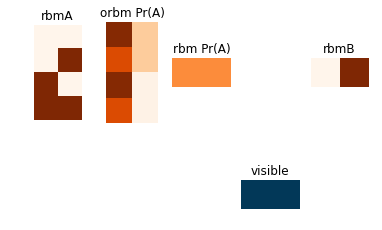

In [7]:
v  = np.array([[1,1]])
hB = np.array([[0,1]])
do_figure('the_approx_way', w, v, hB, version='APPROX')

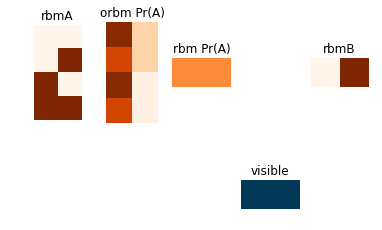

In [8]:
do_figure('the_exact_way', w, v, hB, version='EXACT')

_Note: we show the rbmA state alongside the orbm's Pr(A) here because in theory the orbm probabilities do depend on the existing state. However it is extremely heartening that they don't strongly. Perhaps because this example is just so symmetrical._

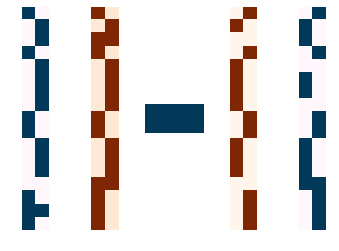

In [9]:
show_reconstructions('reconstructions', w, v=np.array([[1,1]]), version='EXACT')

In [10]:
def logL_orbm(w, train, num_Gibbs_iters=10):
    # estimate the logL from samples.


    # get sample proportions
    
    # KL divergence 
    

SyntaxError: unexpected EOF while parsing (<ipython-input-10-368cdcbbdf0f>, line 8)

In [11]:
def samples_from_orbm_METHOD1(w, num_samples=1000, num_Gibbs_iters=10):
    # make shitloads of samples in the "naive" way, using two entirely separate RBMs, which combine at the last moment.
    samples = np.zeros((num_samples, 2), dtype = int)

    for j in range(num_samples):
        uA = (0.5 > rng.random(size=(1,2))).reshape(1,2)
        uB = (0.5 > rng.random(size=(1,2))).reshape(1,2)
        for i in range(num_Gibbs_iters):
            # set the hidden units in each network, which is a regular RBM.
            psiA, psiB = np.dot(uA,w), np.dot(uB,w)
            hA_prob, hB_prob = sigmoid(psiA), sigmoid(psiB)
            hA = (hA_prob > rng.random(size=hA_prob.shape)).reshape(2,1)
            hB = (hB_prob > rng.random(size=hB_prob.shape)).reshape(2,1)
            # set the "latent" (u) units in the two regular RBMs
            phiA, phiB = np.dot(w,hA).T,  np.dot(w,hB).T
            uA_prob, uB_prob = sigmoid(phiA), sigmoid(phiB)
            uA = (uA_prob > rng.random(size=uA_prob.shape)).reshape(1,2)
            uB = (uB_prob > rng.random(size=uB_prob.shape)).reshape(1,2)
        # finally, combine them to make a visible pattern: our sample
        phiA, phiB = np.dot(w,hA).T,  np.dot(w,hB).T
        vis_prob = sigmoid(phiA + phiB).reshape(1,2)
        v = (vis_prob > rng.random(size=vis_prob.shape))
        samples[j,:] = v
    return samples

In [12]:
def samples_from_orbm_METHOD2(w, num_samples=1000, num_Gibbs_iters=10):
    # make shitloads of samples, by sampling using our scheme...
    samples = np.zeros((num_samples, 2), dtype = int)

    for j in range(num_samples):
        v = (0.5 > rng.random(size=(1,2))).reshape(1,2)  # initial vis pattern
        hA = (0.5 > rng.random(size=(1,2))).reshape(1,2)  # initial vis pattern
        hB = (0.5 > rng.random(size=(1,2))).reshape(1,2)  # initial vis pattern
        for i in range(num_Gibbs_iters):
            # reset the hidden units in the hidden layers, each of which is an ORBM.
            tmp, hA = update_hidden_layer(hA, hB, w, v, 'EXACT')
            tmp, hB = update_hidden_layer(hB, hA, w, v, 'EXACT')
            # reset the visible units.
            phiA, phiB = np.dot(w,hA).T,  np.dot(w,hB).T
            vis_prob = sigmoid(phiA + phiB).reshape(1,2)
            v = (vis_prob > rng.random(size=vis_prob.shape))
        samples[j,:] = v
    return samples

In [15]:
samples = samples_from_orbm_METHOD1(w, num_samples=1000, num_Gibbs_iters=500)
new_array = [tuple(row) for row in samples]
for y in [tuple(pat) for pat in pats]:
    result= [x for x in new_array if x == y]
    print(y, len(result))


(0, 0) 106
(0, 1) 409
(1, 0) 360
(1, 1) 125


In [14]:
samples = samples_from_orbm_METHOD2(w, num_samples=1000, num_Gibbs_iters=500)
new_array = [tuple(row) for row in samples]
for y in [tuple(pat) for pat in pats]:
    result= [x for x in new_array if x == y]
    print(y, len(result))


(0, 0) 87
(0, 1) 400
(1, 0) 432
(1, 1) 81


So with weights of 1 that was pretty affirming: (i) the two methods agree, and (ii) the result seems sensible.

But with larger weights (*5) there's a difference - why?

# Learning from scratch

Fuckity fuck: something's wrong here.

In [22]:
def learn_orbm(w, train, num_train_iters=10, num_Gibbs_iters=10):
    
    eta, momentum = .01, 0.25 # learning parameters
    prev_dw = np.zeros(shape=w.shape)
    for step in range(num_train_iters):
        dw = np.zeros(shape=w.shape)
        # Wake phase
        for v in train: # 'clamped'
            v = v.reshape(1,2) 
            #print('shape of v should be 1,2: ',v.shape)
            # SAMPLE from hA and hB
            # Start by initialising as if it were a vanilla RBM 
            psiA, psiB = np.dot(v,w), np.dot(v,w)
            hA_prob, hB_prob = sigmoid(psiA), sigmoid(psiB)
            hA = (hA_prob > rng.random(size=hA_prob.shape)).reshape(2,1)
            hB = (hB_prob > rng.random(size=hB_prob.shape)).reshape(2,1)
            #print('shape of hA should be 2,1: ',hA.shape)
            for t in range(num_Gibbs_iters):
                # update hA
                tmp, hA = update_hidden_layer(hA, hB, w, v, 'EXACT')
                # update hB
                tmp, hB = update_hidden_layer(hB, hA, w, v, 'EXACT')
    
            phiA, phiB = np.dot(w,hA).T,  np.dot(w,hB).T
            phiA0 = phiA - hA*w 
            phiB0 = phiB - hB*w 
            sigAB_toA  = sigmoid(phiA0 + .5*w + phiB)
            sigAB_toB  = sigmoid(phiB0 + .5*w + phiA)
            dwA = sigmoid(phiA)*hA + (v - sigAB_toA)*hA
            dwB = sigmoid(phiB)*hB + (v - sigAB_toB)*hB
            #COMBINE
            dw = dw + (dwA + dwB)
    
        # Sleep phase
        for v in train: # 'free'
            vA = rng.randint(0,2,(1,2))
            vB = rng.randint(0,2,(1,2))
            for t in range(num_iters):
                # visibles to hiddens
                psiA, psiB = np.dot(vA,w), np.dot(vB,w)
                hA_prob, hB_prob = sigmoid(psiA), sigmoid(psiB)
                hA = (hA_prob > rng.random(size=hA_prob.shape)).reshape(2,1)
                hB = (hB_prob > rng.random(size=hB_prob.shape)).reshape(2,1)
                # hiddens to visibles
                phiA, phiB = np.dot(w,hA), np.dot(w,hB)
                vA_prob, vB_prob = sigmoid(phiA), sigmoid(phiB)
                vA = (vA_prob > rng.random(size=vA_prob.shape)).reshape(1,2)
                vB = (vB_prob > rng.random(size=vB_prob.shape)).reshape(1,2)
    
            dwA = vA*hA  # simple Hebb
            dwB = vB*hB  # simple Hebb
            #COMBINE
            dw = dw - (dwA + dwB)
    
        w = w + eta * (dw  +  momentum * prev_dw)
        prev_dw = dw
    return w

In [23]:
w = 1.0 * np.array([[1,-1],[-1,1]])
train  = np.array([[0,1], [1,0]])# our data points

In [24]:
print('old weights:')
print(w)

w = learn_orbm(w, train, num_train_iters=100, num_Gibbs_iters=1) 
print('new weights:')
print(w)

v  = np.array([[1,1]])
hB = np.array([[0,1]])
do_figure('after_learning', w, v, hB, version='EXACT')

old weights:
[[ 1. -1.]
 [-1.  1.]]


NameError: name 'num_iters' is not defined

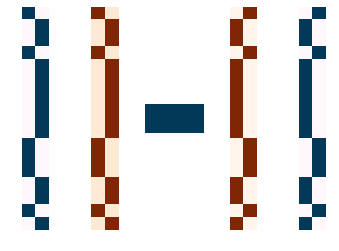

In [221]:
show_reconstructions('reconstructions', w*5, v=np.array([[1,1]]), version='EXACT')

### TODO:
 
 1. two-bit learning: work in progress....
 
 2. 3-visible-bit RBMs, two of them with shared weights.
 
 Something like
  * 001 has logP=1
  * 011 has logP=2
  * 111 has logP=1
 
 3. same but with two sets of weights, learning both of them.
 
Where the complement is
  * 110 has logP=1
  * 100 has logP=2
  * 000 has logP=1
